In [3]:
import pandas as pd
import numpy as np
import evaluation

## load_data

In [4]:
# load prices
prices = pd.read_csv('hackathon_prices_dev.csv', index_col='dates', parse_dates=['dates'])


In [1]:
prices.head()

NameError: name 'prices' is not defined

In [9]:
np.power(prices.ffill().diff(), 2)

,diamonds,butter,cars,cucumber,bananas
dates,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN
2000-01-04,4.3264,11.4921,0.0484,0.8649,0.3364
2000-01-05,1.7689,0.3481,3.8416,1.1025,3.3124
2000-01-06,0.6241,1.5876,2.4025,0.0676,59.5984
2000-01-07,0.1849,2.2201,1.7956,1.1025,10.6929
...,...,...,...,...,...
2023-01-05,4.1209,0.0256,4.8841,0.3364,11.2896
2023-01-06,0.6400,2.8224,9.0601,0.1089,24.1081
2023-01-09,0.2304,2.2201,5.0625,0.7744,1.6384


In [47]:
trend_window, vol_window = 50, 100
ret = prices.ffill().diff()
pos = pd.DataFrame(np.nan, index=ret.index, columns=ret.columns)
t = 100

# Volatility estimate; standard deviation on the last vol_window days, up to t-1
vol = np.sqrt((ret**2).iloc[t-vol_window:t].mean())

In [48]:
vol

diamonds    1.548068
butter      1.989068
cars        2.150341
cucumber    0.930560
bananas     4.146302
dtype: float64

In [49]:
# Mean return between t-trend_window and t-1
block_ret = ret.iloc[t-trend_window:t].sum()

In [53]:
block_ret

diamonds     5.81
butter      10.43
cars         7.24
cucumber     4.09
bananas     32.21
dtype: float64

In [54]:
# Take a long position if the 50-days return is positive, otherwise take a short position (sign of the block return)
unadj_pos = np.sign(block_ret)

In [ ]:
# Position at date t; risk adjust with volatility from previous date
pos.iloc[t+1] = unadj_pos / vol

## enter your own trading strategy here

In [5]:
from sklearn.linear_model import LinearRegression


In [69]:
def train_models(prices, hist_window=150, future_window=10):
    """Train a linear model using historical returns, predicting accumalted future_window days return"""
    ret = prices.ffill().diff().dropna()
    
    models = {column: LinearRegression() for column in ret.columns}
    Xs = {column: [] for column in ret.columns}
    ys = {column: [] for column in ret.columns}
    
    for column, model in models.items():    
        for index in range(hist_window, ret.shape[0]):
            X_cur = ret[column].dropna().iloc[index-hist_window:index].to_numpy()
            y_cur = ret[column].dropna().iloc[index:index + future_window].cumsum().to_numpy()[-1]
            
            Xs[column].append(X_cur)
            ys[column].append(y_cur)
            
    for column, model in models.items():
        model.fit(Xs[column], ys[column])        
    
    return models

In [72]:
def trend_model(prices, models, trend_window=150, vol_window=100):
    ret = prices.ffill().diff().dropna()
    
    pos = pd.DataFrame(np.nan, index=ret.index, columns=ret.columns)
    # loop over all dates
    for t in range(trend_window, ret.shape[0]-1):
        # Volatility estimate; standard deviation on the last vol_window days, up to t-1
        vol = np.sqrt((ret**2).iloc[t-vol_window:t].mean())
        
        # Mean return between t-trend_window and t-1
        # block_ret = ret.iloc[t-trend_window:t].sum()
        return_ = pd.DataFrame(
            {column: model.predict([ret[column].iloc[t-trend_window:t]]) for column, model in models.items()}
        )
        
        # Take a long position if the 50-days return is positive, otherwise take a short position (sign of the block return)
        #unadj_pos = np.sign(block_ret)
        #unadj_pos = np.sign(return_)
        unadj_pos = return_
        
        # Position at date t; risk adjust with volatility from previous date
        pos.iloc[t+1] = unadj_pos / vol
    return pos

In [79]:
prices = pd.read_csv('hackathon_prices_all.csv').set_index('dates')

In [80]:
prices

,fireworks,bread,cucumbers,cheese,candies,soil,stones,books,water,butter,tomatoes,meat,wood,diamonds,bananas
dates,,,,,,,,,,,,,,,
2000-01-03,538.33,805.55,483.84,900.83,922.49,813.71,912.36,1120.67,896.38,312.37,666.15,816.62,601.01,609.16,705.00
2000-01-04,537.79,803.72,481.04,899.64,924.84,814.22,888.29,1097.34,899.97,308.02,661.03,816.37,597.24,610.99,702.57
2000-01-05,535.76,802.67,482.50,883.59,926.93,815.25,887.75,1078.77,895.40,305.77,661.64,817.59,595.80,597.53,698.47
2000-01-06,536.78,806.03,483.00,834.77,926.62,814.88,880.25,1075.56,898.12,305.27,657.47,815.06,594.77,589.44,697.79
2000-01-07,538.07,809.07,483.81,863.08,927.64,816.91,901.34,1091.78,900.64,305.64,657.24,817.01,598.71,592.04,694.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-21,804.99,751.12,912.14,1776.79,1423.39,826.73,1634.57,1353.71,1420.06,619.87,653.35,1117.36,1073.91,949.81,926.63
2023-03-22,815.75,749.47,913.98,1778.38,1418.40,825.03,1625.29,1354.75,1426.56,622.15,657.14,1120.83,1071.31,955.70,928.15
2023-03-23,820.96,749.71,918.18,1780.28,1410.62,825.19,1625.34,1353.66,1432.65,626.80,658.69,1125.19,1077.87,957.94,926.97


In [81]:
position_final = trend_model(prices, models)

In [82]:
position_final.to_csv('results_final_positions.csv')

In [58]:
pos = trend_model(prices, models)
pos_short = trend_model(prices.iloc[:-500], models)
(pos-pos_short).abs().sum()

fireworks    0.0
bread        0.0
cucumbers    0.0
cheese       0.0
candies      0.0
soil         0.0
stones       0.0
books        0.0
water        0.0
butter       0.0
tomatoes     0.0
meat         0.0
wood         0.0
diamonds     0.0
bananas      0.0
dtype: float64

## evaluate results

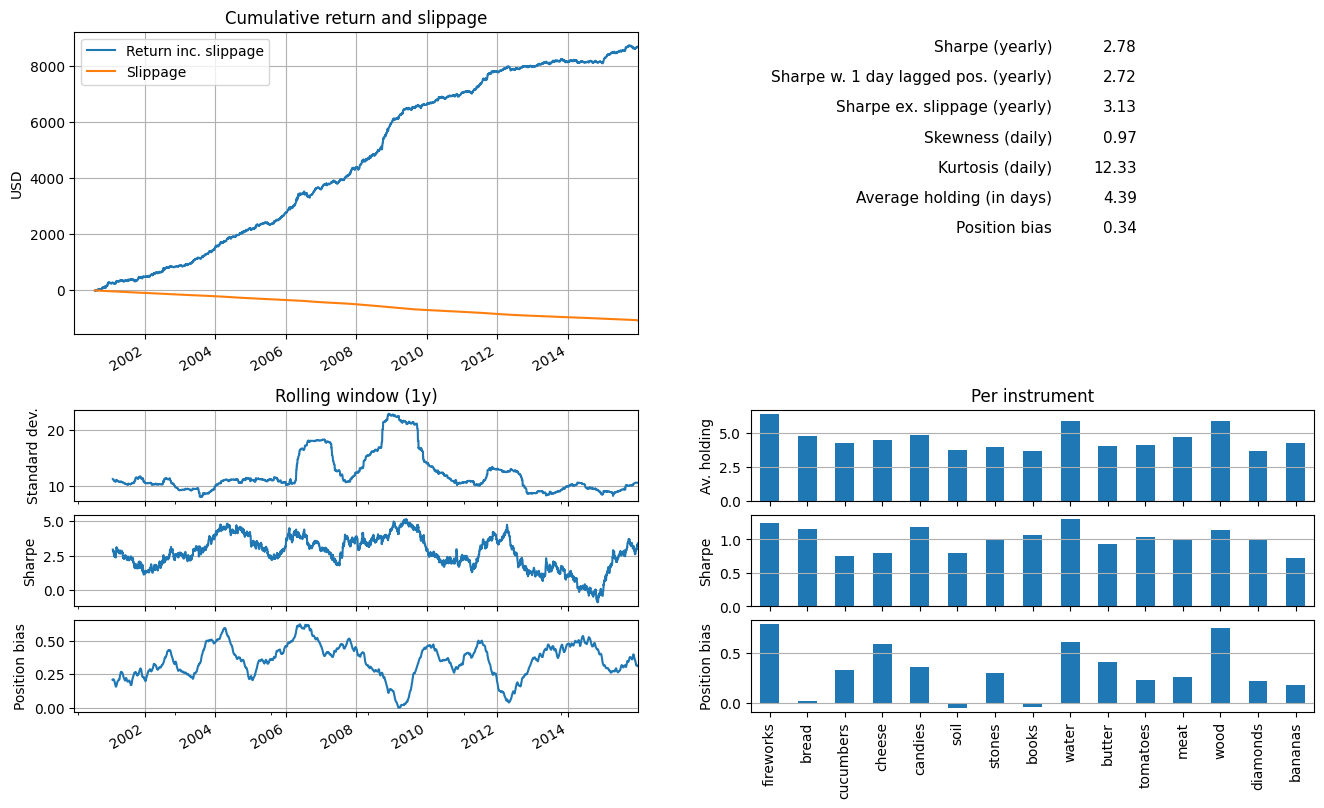

In [74]:
evaluation.plot_key_figures(position, prices)

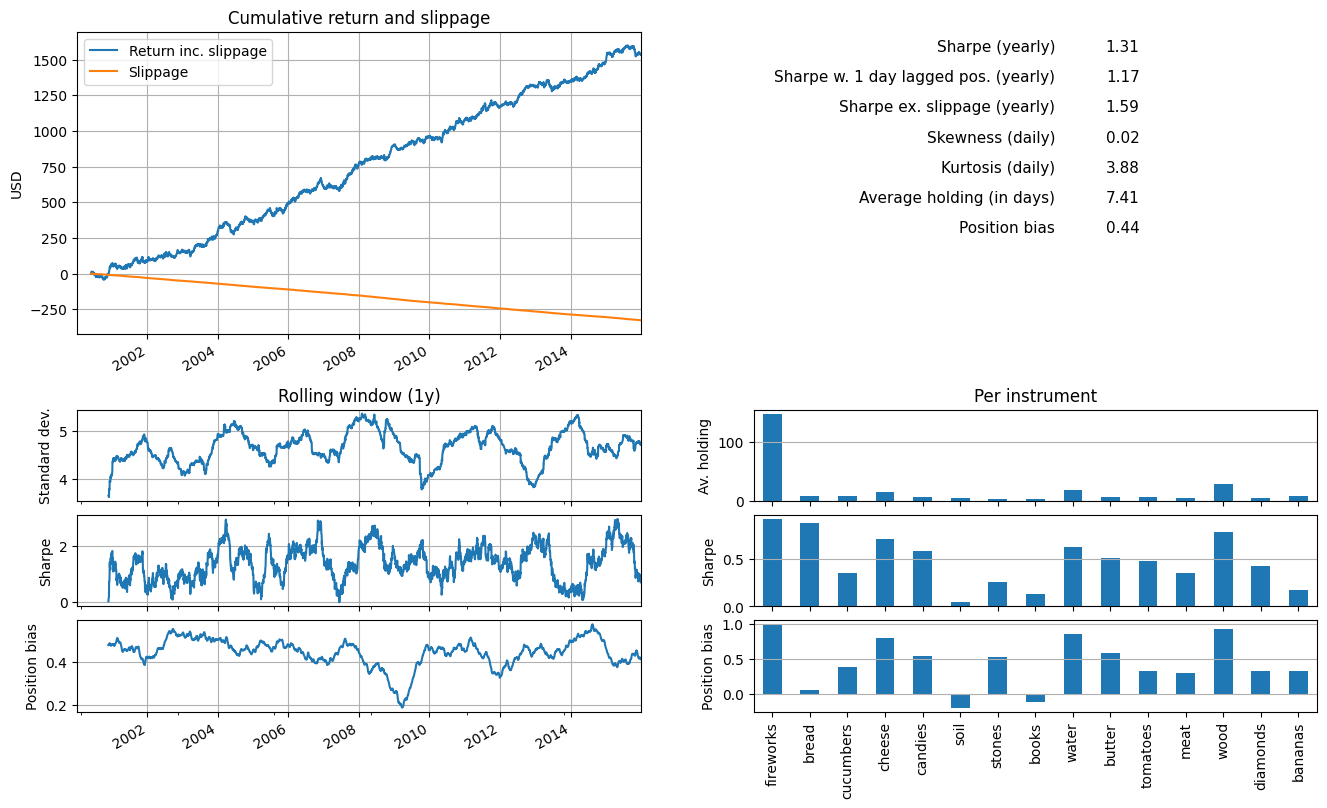

In [24]:
evaluation.plot_key_figures(position, prices)
plt.savefig('best_model.png')

## save your positions to a file

In [75]:
position.to_csv('results_final_final.csv')